In [172]:
#pip install geopandas
import geopandas as gpd
import json
import pathlib
import urllib.parse

import geoalchemy2 as gdb
import matplotlib.pyplot as plt
import pandas as pd
import requests
import shapely
import sqlalchemy as db

from sqlalchemy.orm import declarative_base
from shapely import wkt
import geopy
import geopandas as gpd
from datetime import datetime, timedelta
import os
import glob
import warnings
warnings.filterwarnings('ignore')
import psycopg2
import numpy as np
import seaborn as sns
from shapely.geometry import Point
from geoalchemy2 import Geometry
from pathlib import Path

In [ ]:
##downloading and reading files(when downloading 311, we use filter to only keep these columns:
#latitude,longitude,incident_zip,created_date,location,complaint_type)
#read 311
#read tree
#read zipcode
#raed zillow
#clean zipcode,zillow,tree,311
#

In [3]:
file_311=gpd.read_file('data/resource/nyc_311_data.geojson')


In [4]:
file_311.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 24336507 entries, 0 to 24336506
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   latitude        object        
 1   created_date    datetime64[ns]
 2   longitude       object        
 3   incident_zip    object        
 4   complaint_type  object        
 5   geometry        geometry      
dtypes: datetime64[ns](1), geometry(1), object(4)
memory usage: 1.1+ GB


In [ ]:
#downloading the tree file
def download_nyc_geojson_data(url, token, force=False):
    parsed_url = urllib.parse.urlparse(url)
    url_path = parsed_url.path.strip("/")
    
    filename = pathlib.Path("data") / url_path

    # Create directories if they don't exist
    filename.parent.mkdir(parents=True, exist_ok=True)
    
    if force or not filename.exists():
        print(f"Downloading {url} to {filename}...")
        
        # Set the initial offset
        offset = 0
        limit = 5000000
        
        while True:
            # Include the $limit and $offset parameters in the URL
            query = f"$limit={limit}&$offset={offset}"
            full_url = f"{url}?$$app_token={token}&{query}"

            # Make the request
            response = requests.get(full_url)
            
            # Print debugging information
            print(f"Response status code: {response.status_code}")
            print(f"Response content: {response.text}")

            # Check if the response is not empty
            if response.text:
                try:
                    # Attempt to parse JSON
                    json_data = response.json()
                    with open(filename, "a") as f:  # Append to the file instead of overwriting
                        json.dump(json_data, f)
                    print(f"Downloaded {len(json_data)} records from {url}.")
                    
                    # Check if there are more records
                    if len(json_data) < limit:
                        break
                except json.JSONDecodeError as e:
                    print(f"Error decoding JSON from {url}: {e}")
            else:
                print(f"Empty response received from {url}.")

            # Update the offset for the next page
            offset += limit

    else:
        print(f"Reading from {filename}...")

    return filename

# Set the URL and token
url = "https://data.cityofnewyork.us/resource/5rq2-4hqu.geojson"

token = 'RQR8YRHhtzFqpNTQhQHZDzQUI'
geojson_file_tree = download_nyc_geojson_data(url, token)

Response status code: 200


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Downloaded 3 records from https://data.cityofnewyork.us/resource/5rq2-4hqu.geojson.


In [ ]:
"""
    Download GeoJSON data from a specified URL and save it locally.

    This function downloads data from the given URL, which is expected to return GeoJSON data. It supports pagination through offset-based querying and saves the data in chunks to a local file. The data is saved in the 'data' directory with a filename derived from the URL path. If the 'force' flag is set or the file does not exist, the download is initiated; otherwise, the existing file is used.

    Parameters:
    url (str): The URL from which to download the data. It should return JSON data.
    token (str): An app token used for the API request.
    force (bool): If True, the data will be downloaded afresh even if it already exists. Defaults to False.

    Returns:
    pathlib.Path: The path to the file where the data is saved.

    Raises:
    json.JSONDecodeError: If there is an error in decoding the JSON data from the response.
    """
   

In [5]:
#file_tree=gpd.read_file(geojson_file_tree)
file_tree=gpd.read_file('/Users/tang/4501Final project/data/resource/5rq2-4hqu.geojson')

In [6]:
file_zipcode=gpd.read_file('/Users/tang/4501Final project/data/nyc_zipcodes.shp')

In [7]:
file_zillow=pd.read_csv('/Users/tang/4501Final project/data/zillow_rent_data.csv')

In [ ]:
file_311.head()

latitude        created_date           longitude incident_zip  \
0  40.655672001198894 2023-09-30 23:59:58  -73.95917686020623        11226   
1   40.76675595839554 2023-09-30 23:59:38  -73.78751847563191        11361   
2   40.71949965458691 2023-09-30 23:59:35  -73.98486650733275        10002   
3  40.687499303408536 2023-09-30 23:59:34   -73.7972903094197        11435   
4   40.65220215349917 2023-09-30 23:59:28   -73.9579464603267        11226   

            complaint_type                    geometry  
0  Noise - Street/Sidewalk  POINT (-73.95918 40.65567)  
1      Noise - Residential  POINT (-73.78752 40.76676)  
2       Noise - Commercial  POINT (-73.98487 40.71950)  
3      Noise - Residential  POINT (-73.79729 40.68750)  
4      Noise - Residential  POINT (-73.95795 40.65220)

In [ ]:
#clean zipcode first
#clean zillow
#clean tree
#clean 311

In [15]:
##clean zipcode

#step1-rename ZIPCODE
zipcode_1 = file_zipcode.rename(columns={'ZIPCODE': 'zipcode'})

#step2-keep useful columns
zipcode_keep_2=zipcode_1[['zipcode','geometry']]

#There is no na in zipcode file


#drop duplicates
zipcode_dropduplicates_3=zipcode_keep_2.drop_duplicates(subset='zipcode')

#step2-adjust srid
#use the “center” of the zones (polygons) as a point to look up the coordinates
cleaned_zipcode = zipcode_dropduplicates_3.to_crs(4326)

cleaned_zipcode.head()

zipcode                                           geometry
0   11436  POLYGON ((-73.80585 40.68291, -73.80569 40.682...
1   11213  POLYGON ((-73.93740 40.67973, -73.93487 40.679...
2   11212  POLYGON ((-73.90294 40.67084, -73.90223 40.668...
3   11225  POLYGON ((-73.95797 40.67066, -73.95576 40.670...
4   11218  POLYGON ((-73.97208 40.65060, -73.97192 40.650...

In [16]:
cleaned_zipcode.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 248 entries, 0 to 262
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   zipcode   248 non-null    object  
 1   geometry  248 non-null    geometry
dtypes: geometry(1), object(1)
memory usage: 5.8+ KB


In [57]:

#step1-Rename 'RegionID' to 'ZIPCODE'
df_zillow_data_1 = file_zillow.rename(columns={'RegionName': 'zipcode'})
#drop unuseful columns
keep_column_zillow_2 = df_zillow_data_1.drop(columns=['RegionID', 'SizeRank','RegionType','StateName','State','City','Metro','CountyName'])
#fill na value with 0
fillna0_zillow_3=keep_column_zillow_2.fillna(0)
#filter only the nyc zipcode
cleaned_zillow=fillna0_zillow_3[fillna0_zillow_3['zipcode'].astype(str).isin(cleaned_zipcode['zipcode'].astype(str))]
#drop duplicates
cleaned_zillow.drop_duplicates(subset=['zipcode'], inplace=True)


In [64]:
cleaned_zillow.insert(0, 'id', range(1, 1 + len(cleaned_zillow)))
cleaned_zillow.head()

id  zipcode  2015-01-31   2015-02-28  2015-03-31   2015-04-30  \
4    1    11385         0.0  2087.527084         0.0  2149.924252   
6    2    11208         0.0     0.000000         0.0     0.000000   
12   3    11236         0.0     0.000000         0.0     0.000000   
13   4    10467         0.0     0.000000         0.0     0.000000   
14   5    11373         0.0     0.000000         0.0     0.000000   

     2015-05-31   2015-06-30   2015-07-31   2015-08-31  ...   2022-12-31  \
4   2166.263698  2148.992886  2190.098591  2264.966715  ...  2935.808220   
6      0.000000     0.000000     0.000000     0.000000  ...  2508.670432   
12     0.000000     0.000000     0.000000     0.000000  ...     0.000000   
13     0.000000     0.000000     0.000000     0.000000  ...  2145.642295   
14     0.000000     0.000000     0.000000     0.000000  ...  2199.459063   

     2023-01-31   2023-02-28   2023-03-31   2023-04-30   2023-05-31  \
4   2895.699421  2873.209025  2881.906361  2913.546218  2963.964134   
6   2588.030194  2613.790654  2585.561351  2633.200754  2672.038493   
12     0.000000     0.000000     0.000000     0.000000     0.000000   
13  2155.617718  2172.346611  2160.962748  2110.533203  2180.323655   
14  2255.604528  2262.101623  2271.514956  2250.182334  2231.959479   

     2023-06-30   2023-07-31   2023-08-31   2023-09-30  
4   3005.735342  3034.413822  3064.476503  3079.585783  
6   2806.918757  2765.224364  2737.547470  2728.733333  
12     0.000000     0.000000  2285.460026  2362.500000  
13  2276.372290  2334.204728  2353.686402  2423.888889  
14  2257.413993  2247.592851  2302.557354  2292.994444  

[5 rows x 107 columns]

In [19]:
cleaned_zillow.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, 4 to 6721
Columns: 106 entries, zipcode to 2023-09-30
dtypes: float64(105), int64(1)
memory usage: 122.0 KB


In [20]:
##clean tree(no duplicates in tree)
#rename zipcode to ZIPCODE, spc_common to species
tree_columns_tokeep=file_tree[['tree_id','latitude','longitude','spc_common','zipcode','health','status','geometry']].rename(columns={'spc_common':'species'})
tree_filter_zipcode=tree_columns_tokeep[tree_columns_tokeep['zipcode'].astype(str).isin(cleaned_zipcode['zipcode'].astype(str))]

cleaned_tree=tree_filter_zipcode.dropna()


In [21]:
cleaned_tree.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 652167 entries, 0 to 683787
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   tree_id    652167 non-null  object  
 1   latitude   652167 non-null  object  
 2   longitude  652167 non-null  object  
 3   species    652167 non-null  object  
 4   zipcode    652167 non-null  object  
 5   health     652167 non-null  object  
 6   status     652167 non-null  object  
 7   geometry   652167 non-null  geometry
dtypes: geometry(1), object(7)
memory usage: 44.8+ MB


In [22]:
cleaned_tree.head()

tree_id     latitude     longitude          species zipcode health status  \
0  180683  40.72309177  -73.84421522        red maple   11375   Fair  Alive   
1  200540  40.79411067  -73.81867946          pin oak   11357   Fair  Alive   
2  204026  40.71758074   -73.9366077      honeylocust   11211   Good  Alive   
3  204337  40.71353749  -73.93445616      honeylocust   11211   Good  Alive   
4  189565  40.66677776  -73.97597938  American linden   11215   Good  Alive   

                     geometry  
0  POINT (-73.84422 40.72309)  
1  POINT (-73.81868 40.79411)  
2  POINT (-73.93661 40.71758)  
3  POINT (-73.93446 40.71354)  
4  POINT (-73.97598 40.66678)

In [ ]:
##clean 311
file_311.head()

latitude        created_date           longitude incident_zip  \
0  40.655672001198894 2023-09-30 23:59:58  -73.95917686020623        11226   
1   40.76675595839554 2023-09-30 23:59:38  -73.78751847563191        11361   
2   40.71949965458691 2023-09-30 23:59:35  -73.98486650733275        10002   
3  40.687499303408536 2023-09-30 23:59:34   -73.7972903094197        11435   
4   40.65220215349917 2023-09-30 23:59:28   -73.9579464603267        11226   

            complaint_type                    geometry  
0  Noise - Street/Sidewalk  POINT (-73.95918 40.65567)  
1      Noise - Residential  POINT (-73.78752 40.76676)  
2       Noise - Commercial  POINT (-73.98487 40.71950)  
3      Noise - Residential  POINT (-73.79729 40.68750)  
4      Noise - Residential  POINT (-73.95795 40.65220)

In [23]:
#dropna_311=file_311.dropna()
rename_311 = file_311.rename(columns={'incident_zip': 'zipcode'})
dropduplicate_311=rename_311.drop_duplicates()
#filter only the nyc zipcode
cleaned_311=dropduplicate_311[dropduplicate_311['zipcode'].astype(str).isin(cleaned_zipcode['zipcode'].astype(str))]
cleaned_311.head()


latitude        created_date           longitude zipcode  \
0  40.655672001198894 2023-09-30 23:59:58  -73.95917686020623   11226   
1   40.76675595839554 2023-09-30 23:59:38  -73.78751847563191   11361   
2   40.71949965458691 2023-09-30 23:59:35  -73.98486650733275   10002   
3  40.687499303408536 2023-09-30 23:59:34   -73.7972903094197   11435   
4   40.65220215349917 2023-09-30 23:59:28   -73.9579464603267   11226   

            complaint_type                    geometry  
0  Noise - Street/Sidewalk  POINT (-73.95918 40.65567)  
1      Noise - Residential  POINT (-73.78752 40.76676)  
2       Noise - Commercial  POINT (-73.98487 40.71950)  
3      Noise - Residential  POINT (-73.79729 40.68750)  
4      Noise - Residential  POINT (-73.95795 40.65220)

In [24]:
cleaned_311=cleaned_311.dropna()

In [ ]:
cleaned_311.head()

latitude        created_date           longitude ZIPCODE  \
0  40.655672001198894 2023-09-30 23:59:58  -73.95917686020623   11226   
1   40.76675595839554 2023-09-30 23:59:38  -73.78751847563191   11361   
2   40.71949965458691 2023-09-30 23:59:35  -73.98486650733275   10002   
3  40.687499303408536 2023-09-30 23:59:34   -73.7972903094197   11435   
4   40.65220215349917 2023-09-30 23:59:28   -73.9579464603267   11226   

            complaint_type                    geometry  
0  Noise - Street/Sidewalk  POINT (-73.95918 40.65567)  
1      Noise - Residential  POINT (-73.78752 40.76676)  
2       Noise - Commercial  POINT (-73.98487 40.71950)  
3      Noise - Residential  POINT (-73.79729 40.68750)  
4      Noise - Residential  POINT (-73.95795 40.65220)

#part2

In [ ]:
##create database
!/Applications/Postgres.app/Contents/Versions/latest/bin/createdb FinalProject4501
!/Applications/Postgres.app/Contents/Versions/latest/bin/psql --dbname FinalProject4501 -c 'CREATE EXTENSION postgis;'


CREATE EXTENSION


#create tables and insert data


In [30]:
conn=psycopg2.connect('postgresql://localhost/FinalProject4501')
engine = db.create_engine('postgresql://localhost/FinalProject4501')


In [143]:
#!!! Create a function to convert GeoDataFrame for SQL upload
def convert_geodf_for_sql(geodf, geometry_type='POINT', srid=4326):
    geodf_for_sql = geodf.copy()
    # Ensure the CRS is set to EPSG:4326
    if geodf_for_sql.crs.to_epsg() != 4326:
        geodf_for_sql = geodf_for_sql.to_crs(epsg=4326)
    # Convert geometry to WKT
    geodf_for_sql['geometry'] = geodf_for_sql['geometry'].apply(lambda x: x.wkt)
    dtype = {'geometry': Geometry(geometry_type=geometry_type, srid=srid)}
    return geodf_for_sql, dtype

In [ ]:
#schema.sql for 311
three11_SCHEMA = """
CREATE TABLE IF NOT EXISTS three11s(
    id SERIAL PRIMARY KEY, 
    created_date DATE,
    complaint_type VARCHAR(200),
    zipcode VARCHAR(200),
    latitude FLOAT,
    longitude FLOAT,
    geometry GEOMETRY (POINT, 4326)
);

"""
with engine.connect() as connection:
    connection.execute(three11_SCHEMA)
    connection.execute("COMMIT;")

three11_sql, zip_dtype = convert_geodf_for_sql(cleaned_311)

# upload dataframe
three11_sql.to_sql('three11s', engine, if_exists='append', index=False, dtype=zip_dtype)


In [ ]:
#schema.sql for zipcode
ZIPCODE_SCHEMA = """
CREATE TABLE IF NOT EXISTS zipcodes (
    zipcode VARCHAR(200) PRIMARY KEY, 
    geometry GEOMETRY (POLYGON,4326)
);
"""


with engine.connect() as connection:
    connection.execute(ZIPCODE_SCHEMA)
    connection.execute("COMMIT;")

zipcode_sql, zip_dtype = convert_geodf_for_sql(cleaned_zipcode,'POLYGON',4326)

# upload dataframe
zipcode_sql.to_sql('zipcodes', engine, if_exists='append', index=False, dtype=zip_dtype)


In [144]:
#schema.sql for tree
TREE_SCHEMA = """
CREATE TABLE IF NOT EXISTS trees (
    tree_id INT PRIMARY KEY,
    latitude FLOAT,
    longitude FLOAT,
    species VARCHAR(60),
    zipcode VARCHAR(60),
    health VARCHAR(60),
    status VARCHAR(60),
    geometry GEOMETRY (POINT, 4326)
);
"""
with engine.connect() as connection:
    connection.execute(TREE_SCHEMA)
    connection.execute("COMMIT;")



In [146]:
tree_sql, zip_dtype = convert_geodf_for_sql(cleaned_tree)

# upload dataframe
tree_sql.to_sql('trees', engine, if_exists='append', index=False, dtype=zip_dtype)


167

In [68]:
#schema for zillow
from sqlalchemy import create_engine, Column, Integer, Float, DateTime, String
import sqlalchemy
Base = declarative_base()

class Zillow(Base):
    __tablename__ = 'zillows'
    id = Column(Integer, primary_key=True,nullable=False)

def define_schema_from_dataframe(df, cls):
    for col, dtype in zip(df.columns, df.dtypes):
        if col == 'id':
            continue
        if dtype == 'int64':
            setattr(cls, col, Column(col, Integer()))
        elif dtype == 'float64':
            setattr(cls, col, Column(col, Float()))
        elif dtype == 'datetime64[ns]':
            setattr(cls, col, Column(col, DateTime()))
        else: 
            setattr(cls, col, Column(col, String()))

# Check if the table already exists
if Zillow.__table__.exists(bind=engine):
    # Drop the table if it exists
    Zillow.__table__.drop(engine)
    
# Create the tables in the database
Base.metadata.create_all(engine)


In [199]:
#!!!unit test for function 'define_schema_from_dataframe()'
import unittest
from sqlalchemy import Column, Integer, Float, DateTime, String
from datetime import datetime
class TestDefineSchemaFromDataFrame(unittest.TestCase):
    def test_define_schema(self):
        # Create a sample DataFrame
        data = {'id': [1, 2], 
                'int_column': [10, 20], 
                'float_column': [1.1, 2.2], 
                'datetime_column': [datetime.now(), datetime.now()],
                'string_column': ['a', 'b']}
        df = pd.DataFrame(data)

        class DummyClass:
            pass

        # Apply the function to define schema
        define_schema_from_dataframe(df, DummyClass)

        # Assertions
        self.assertTrue(hasattr(DummyClass, 'int_column') and isinstance(getattr(DummyClass, 'int_column').type, Integer))
        self.assertTrue(hasattr(DummyClass, 'float_column') and isinstance(getattr(DummyClass, 'float_column').type, Float))
        self.assertTrue(hasattr(DummyClass, 'datetime_column') and isinstance(getattr(DummyClass, 'datetime_column').type, DateTime))
        self.assertTrue(hasattr(DummyClass, 'string_column') and isinstance(getattr(DummyClass, 'string_column').type, String))

# Create a test suite
suite = unittest.TestLoader().loadTestsFromTestCase(TestDefineSchemaFromDataFrame)

# Run the tests
unittest.TextTestRunner().run(suite)

.
----------------------------------------------------------------------
Ran 1 test in 0.022s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [69]:
define_schema_from_dataframe(cleaned_zillow, Zillow)

In [70]:
# Upload 'cleaned_zillow' to 'zillows' table
cleaned_zillow.to_sql('zillows', con=engine, if_exists='replace', index=False)


146

Till now, all table creating and inserting is done! Let's check for results:

In [138]:
#testing table trees
test_trees_srid = '''SELECT ST_SRID(geometry) FROM trees LIMIT 2;
'''
test_trees_primary_key = '''SELECT column_name, is_nullable
    FROM information_schema.columns
    WHERE table_name = 'trees';
'''
test_trees_dtypes = '''SELECT column_name, udt_name
    FROM information_schema.columns
    WHERE table_name = 'trees';
'''
test_tree1 = pd.read_sql(test_trees_srid, engine)
test_tree2 = pd.read_sql(test_trees_primary_key, engine)
test_tree3 = pd.read_sql(test_trees_dtypes, engine)
print(test_tree1)
print(test_tree2)
print(test_tree3)


   st_srid
0     4326
1     4326
  column_name is_nullable
0     tree_id          NO
1    latitude         YES
2   longitude         YES
3     species         YES
4     zipcode         YES
5      health         YES
6      status         YES
7    geometry         YES
  column_name  udt_name
0     tree_id      int4
1    latitude    float8
2   longitude    float8
3     species   varchar
4     zipcode   varchar
5      health   varchar
6      status   varchar
7    geometry  geometry


In [74]:
#testing table three11s
test_three11s_srid = '''SELECT ST_SRID(geometry) FROM three11s LIMIT 1;
'''
test_three11s_primary_key = '''SELECT column_name, is_nullable
    FROM information_schema.columns
    WHERE table_name = 'three11s';
'''
test_three11s_dtypes = '''SELECT column_name, udt_name
    FROM information_schema.columns
    WHERE table_name = 'three11s';
'''
test_three11s1 = pd.read_sql(test_three11s_srid, engine)
test_three11s2 = pd.read_sql(test_three11s_primary_key, engine)
test_three11s3 = pd.read_sql(test_three11s_dtypes, engine)
print(test_three11s1)
print(test_three11s2)
print(test_three11s3)

   st_srid
0     4326
      column_name is_nullable
0              id          NO
1    created_date         YES
2  complaint_type         YES
3         zipcode         YES
4        latitude         YES
5       longitude         YES
6        geometry         YES
      column_name  udt_name
0              id      int4
1    created_date      date
2  complaint_type   varchar
3         zipcode   varchar
4        latitude    float8
5       longitude    float8
6        geometry  geometry


In [75]:
#testing table zipcodes
test_zipcodes_srid = '''SELECT ST_SRID(geometry) FROM zipcodes LIMIT 1;
'''
test_zipcodes_primary_key = '''SELECT column_name, is_nullable
    FROM information_schema.columns
    WHERE table_name = 'zipcodes';
'''
test_zipcodes_dtypes = '''SELECT column_name, udt_name
    FROM information_schema.columns
    WHERE table_name = 'zipcodes';
'''
test_zipcodes1 = pd.read_sql(test_zipcodes_srid, engine)
test_zipcodes2 = pd.read_sql(test_zipcodes_primary_key, engine)
test_zipcodes3 = pd.read_sql(test_zipcodes_dtypes, engine)
print(test_zipcodes1)
print(test_zipcodes2)
print(test_zipcodes3)

   st_srid
0     4326
  column_name is_nullable
0     zipcode          NO
1    geometry         YES
  column_name  udt_name
0     zipcode   varchar
1    geometry  geometry


In [77]:
#testing table zillows
test_zillows_primary_key = '''SELECT column_name, is_nullable
    FROM information_schema.columns
    WHERE table_name = 'zillows';
'''
test_zillows_dtypes = '''SELECT column_name, udt_name
    FROM information_schema.columns
    WHERE table_name = 'zillows';
'''
test_zillows2 = pd.read_sql(test_zillows_primary_key, engine)
test_zillows3 = pd.read_sql(test_zillows_dtypes, engine)

print(test_zillows2)
print(test_zillows3)

    column_name is_nullable
0            id          NO
1       zipcode         YES
2    2015-01-31         YES
3    2015-02-28         YES
4    2015-03-31         YES
..          ...         ...
102  2023-05-31         YES
103  2023-06-30         YES
104  2023-07-31         YES
105  2023-08-31         YES
106  2023-09-30         YES

[107 rows x 2 columns]
    column_name udt_name
0            id     int8
1       zipcode     int8
2    2015-01-31   float8
3    2015-02-28   float8
4    2015-03-31   float8
..          ...      ...
102  2023-05-31   float8
103  2023-06-30   float8
104  2023-07-31   float8
105  2023-08-31   float8
106  2023-09-30   float8

[107 rows x 2 columns]


In [ ]:
"""!!!function changed+test added
This module is designed to set up and interact with a PostgreSQL database for storing and managing data. 
It utilizes SQLAlchemy for ORM (Object-Relational Mapping) and GeoAlchemy2 for geographical data handling.

Key Components:
- `create_engine`: Establishes a connection to a PostgreSQL database located at 'postgresql://localhost/FinalProject4501'.
- `Base`: A declarative base class from which all model classes inherit.
- `Three11s` 'trees' 'zipcodes' 'zillows': model class representing the data. It includes fields for id, creation date, location (latitude, longitude), incident zip code, complaint type, and geometrical data for the point location.
- `Geometry`: A GeoAlchemy2 datatype for storing geographical data, specifically point data with a spatial reference ID (SRID) of 4326.

Functionalities:
1. Creating the PostgreSQL engine for database interactions.
2. Defining the model with necessary fields, including geographical data.
3. Executing a database command to ensure the 'postgis' extension is available in PostgreSQL.
4. Dropping all existing tables if necessary, to reset the database schema.
5. Creating new tables based on the defined models.
6. Handling the insertion of data (assumed to be in the DataFrame) into the tables. The code ensures the 'id' column is auto-generated by PostgreSQL and not included in the DataFrame.

Notes:
- The database connection is managed using a context manager to ensure proper resource handling.
- It is assumed that the DataFrame is preprocessed and available for insertion into the database.
"""


In [82]:
#1. 

#create query1 file
query1='data/q1_complaints_per_zip.sql'

# Create a database connection
# SQL query
query = """
SELECT e.zipcode, COUNT(*) AS ComplaintCount
FROM  Three11s e
WHERE e.created_date >= '2022-10-01' AND e.created_date <= '2023-09-30'
GROUP BY e.zipcode
ORDER BY ComplaintCount DESC;

"""

#write query to file
with open(query1,'w') as file:
    file.write(query)
# Execute the query and store results in a DataFrame
q1_complaints_per_zip = pd.read_sql(query, engine)

# Display the DataFrame
q1_complaints_per_zip

zipcode  complaintcount
0     11226           46540
1     10467           44898
2     11385           42974
3     10468           42239
4     10452           41460
..      ...             ...
226   10155               4
227   00083               2
228   10055               2
229   10080               1
230   10175               1

[231 rows x 2 columns]

In [83]:
#2
#create query2 file
query2='data/q2_top_trees_zipcodes.sql'

query = """
SELECT zipcode, COUNT(*) AS NumberOfTrees
FROM trees
GROUP BY zipcode
ORDER BY NumberOfTrees DESC
LIMIT 10;

"""
#write query to file
with open(query2,'w') as file:
    file.write(query)

# Execute the query and store results in a DataFrame
q2_top_trees_zipcodes = pd.read_sql(query, engine)

# Display the DataFrame
q2_top_trees_zipcodes

zipcode  numberoftrees
0   10312          21356
1   10314          16330
2   10306          12616
3   10309          12105
4   11234          10838
5   11385          10262
6   11357           9016
7   11207           8293
8   11208           7896
9   11434           7833

In [87]:
#3
#create query3 file
query3='data/q3_affordable_trees_area.sql'

query = """
WITH TopTreeZipCodes AS (
    SELECT zipcode, COUNT(*) AS total_trees
    FROM trees
    GROUP BY zipcode
    ORDER BY COUNT(*) DESC
    LIMIT 10
)
SELECT t.zipcode, TO_CHAR(AVG(z."2023-08-31"), 'FM9,999,999.99') AS average_rent
FROM TopTreeZipCodes t
JOIN zillows z ON t.zipcode::bigint= z.zipcode
GROUP BY t.zipcode, t.total_trees
ORDER BY t.total_trees DESC;

"""

#write query to file
with open(query3,'w') as file:
    file.write(query)
    
# Execute the query and store results in a DataFrame
q3_affordable_trees_area = pd.read_sql(query, engine)

# Display the DataFrame
print(q3_affordable_trees_area)


  zipcode average_rent
0   10312     1,775.09
1   10314     2,465.47
2   10306     2,331.54
3   10309     1,832.01
4   11234     2,312.31
5   11385     3,064.48
6   11357     2,458.81
7   11207     3,079.09
8   11208     2,737.55
9   11434     2,645.92


In [92]:
#4.
#create query4 file
query4='data/q4_rent_tree_complaint.sql'

query = """
WITH Rent AS (
    SELECT zipcode, AVG("2023-01-31") AS average_rent
    FROM zillows
    GROUP BY zipcode
    HAVING AVG("2023-01-31") > 0 -- Exclude ZIP codes with an average rent of 0
),
TreeCount AS (
    SELECT zipcode::bigint, COUNT(*) as tree_count
    FROM trees
    GROUP BY zipcode
),
ComplaintCount AS (
    SELECT zipcode::bigint, COUNT(*) as complaint_count
    FROM three11s
    WHERE created_date >= '2023-01-01' AND created_date <= '2023-01-31'
    GROUP BY zipcode
),
RankedRent AS (
    SELECT zipcode, TO_CHAR(average_rent, 'FM9,999,999.99') AS formatted_average_rent, average_rent,
           DENSE_RANK() OVER (ORDER BY average_rent DESC) AS high_rank,
           DENSE_RANK() OVER (ORDER BY average_rent ASC) AS low_rank
    FROM Rent
)

SELECT rr.zipcode, rr.formatted_average_rent, tc.tree_count, cc.complaint_count
FROM RankedRent rr
LEFT JOIN TreeCount tc ON rr.zipcode = tc.zipcode
LEFT JOIN ComplaintCount cc ON rr.zipcode = cc.zipcode
WHERE rr.high_rank <= 5 OR rr.low_rank <= 5
ORDER BY rr.average_rent DESC, rr.high_rank, rr.low_rank;

"""

#write query to file
with open(query4,'w') as file:
    file.write(query)
    
# Execute the query and store results in a DataFrame
q4_rent_tree_complaint = pd.read_sql(query, engine)


# Display the DataFrame
print(q4_rent_tree_complaint)

   zipcode formatted_average_rent  tree_count  complaint_count
0    10007               7,270.24         338              232
1    10282               7,143.35         230               42
2    10013               5,480.11        1132              747
3    10069               4,959.67         112               36
4    10011               4,741.87        2040             1474
5    10458               1,883.08        3212             3556
6    11357               1,829.66        9016              876
7    10453               1,820.23        2874             2864
8    10462               1,801.89        4048             2253
9    10309               1,380.51       12105              793


In [142]:
task = """
SELECT ST_AsText(geometry) FROM trees LIMIT 1;

"""
# Execute the query and store results in a DataFrame
df = pd.read_sql(task, engine)

# Display the DataFrame
print(df)

                                     st_astext
0  POINT(-8220300.436272602 4971583.163269759)


In [147]:
#5
#create query5 file
query5='data/q5_most_greenery_zipcodes.sql'

query = """
SELECT z.zipcode, COUNT(t.tree_id) AS total_trees
FROM zipcodes z 
JOIN trees t ON z.zipcode = t.zipcode 
WHERE ST_Within(t.geometry, z.geometry)
GROUP BY z.zipcode
ORDER BY total_trees DESC
LIMIT 10;

"""

#write query to file
with open(query5,'w') as file:
    file.write(query)

# Execute the query and store results in a DataFrame
q5_most_greenery_zipcodes = pd.read_sql(query, engine)

# Display the DataFrame
print(q5_most_greenery_zipcodes)

  zipcode  total_trees
0   10312        21356
1   10314        16330
2   10306        12616
3   10309        12105
4   11234        10838
5   11385        10262
6   11357         9016
7   11207         8293
8   11208         7896
9   11434         7833


In [150]:
#6
#create query6 file
query6='data/q6_trees_within_half_mile.sql'

query = """
SELECT trees.tree_id, trees.tree_id, trees.species, trees.health, trees.status, ST_AsText(trees.geometry) AS coordinates
FROM trees 
WHERE ST_DWithin(
    ST_SetSRID(ST_MakePoint(-73.96253174434912, 40.80737875669467), 4326)::geography,
    ST_Transform(trees.geometry, 4326)::geography,
    0.5 * 1609.34 -- Convert 0.5 miles to meters
)

"""

#write query6 to file
with open(query6,'w') as file:
    file.write(query)

q6_trees_within_half_mile = pd.read_sql(query, engine)
print(q6_trees_within_half_mile)

     tree_id tree_id           species health status  \
0     198514  198514           pin oak   Good  Alive   
1     209919  209919  London planetree   Good  Alive   
2     209921  209921  London planetree   Good  Alive   
3     203887  203887        willow oak   Good  Alive   
4     196440  196440      American elm   Fair  Alive   
...      ...     ...               ...    ...    ...   
2767  198513  198513  northern red oak   Good  Alive   
2768  203888  203888  Japanese zelkova   Fair  Alive   
2769  198508  198508           pin oak   Good  Alive   
2770  187144  187144           pin oak   Good  Alive   
2771  187077  187077            ginkgo   Good  Alive   

                                       coordinates  
0      POINT(-73.96207980385901 40.80230108588602)  
1     POINT(-73.96331506361766 40.808811547267055)  
2      POINT(-73.96340334087577 40.80874458097537)  
3     POINT(-73.96071917063361 40.805725833688264)  
4      POINT(-73.96412322243684 40.81114537770991)  
...      

In [151]:
#1.
def get_top_complaint_types(engine):
    query = """
    SELECT complaint_type, COUNT(*) AS count
    FROM three11s
    WHERE created_date BETWEEN '2022-10-01' AND '2023-09-30'
    GROUP BY complaint_type
    ORDER BY count DESC
    LIMIT 3;
    """
    top_complaints = pd.read_sql(query, engine)
    return top_complaints['complaint_type'].tolist()

top_complaint_types = get_top_complaint_types(engine)
top_complaint_types

['Illegal Parking', 'Noise - Residential', 'HEAT/HOT WATER']

In [202]:
#!!!unit test
class TestGetTopComplaintTypes(unittest.TestCase):
    def test_top_complaint_types(self):
        # Setup: create a test engine (replace with your test database credentials)
        engine = create_engine('postgresql://localhost/FinalProject4501')

        # Call the function
        top_complaint_types = get_top_complaint_types(engine)

        # Assertions
        self.assertIsInstance(top_complaint_types, list, "Output should be a list")
        self.assertEqual(len(top_complaint_types), 3, "List should contain exactly three items")

# Create a test suite
suite = unittest.TestLoader().loadTestsFromTestCase(TestGetTopComplaintTypes)

# Run the tests
unittest.TextTestRunner().run(suite)


.
----------------------------------------------------------------------
Ran 1 test in 6.183s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [ ]:

    """
    Retrieves the top three complaint types based on their frequency over a specified period.

    This function executes a SQL query to find the most common complaint types in the 'three11' table
    within a one-year period, from October 1, 2022, to September 30, 2023. It returns a list of the top 
    three complaint types sorted in descending order of occurrence.

    Parameters:
    - engine: The SQLAlchemy engine object used for database connection and query execution.

    Returns:
    - A list of strings, where each string is a complaint type. The list contains the top three 
      complaint types occurring most frequently in the specified date range.

    Example:
    >>> engine = create_engine('postgresql://localhost/finalproject1')
    >>> top_complaint_types = get_top_complaint_types(engine)
    >>> print(top_complaint_types)
    ['Noise - Residential', 'Illegal Parking', 'Blocked Driveway']

    Note:
    - The function assumes that the 'three11' table and the specified date range exist in the database.
    - The function uses pandas to execute the SQL query and process the result.
    """
    # Function implementation...


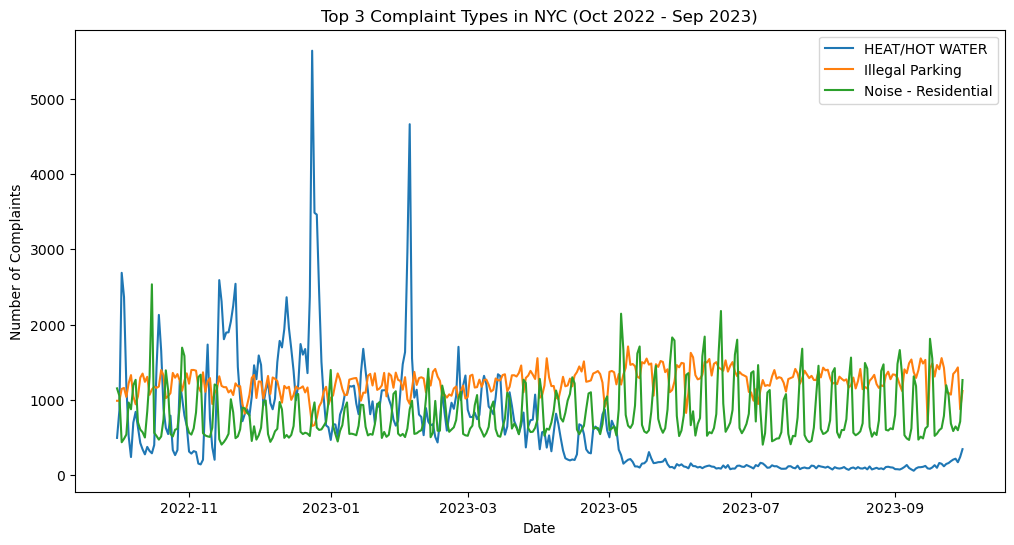

In [152]:
def plot_complaint_types(engine, top_complaint_types):
    # Format the list of complaint types for SQL query
    complaint_types_str = "'" + "', '".join(top_complaint_types) + "'"

    # Updated query with actual complaint types
    query = f"""
    SELECT created_date, complaint_type, COUNT(*) AS daily_count
    FROM three11s
    WHERE complaint_type IN ({complaint_types_str})
    AND created_date BETWEEN '2022-10-01' AND '2023-09-30'
    GROUP BY created_date, complaint_type;
    """
    df = pd.read_sql(query, engine)

    pivot_df = df.pivot(index='created_date', columns='complaint_type', values='daily_count')

    # Plotting
    plt.figure(figsize=(12, 6))
    for column in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[column], label=column)

    plt.xlabel('Date')
    plt.ylabel('Number of Complaints')
    plt.title('Top 3 Complaint Types in NYC (Oct 2022 - Sep 2023)')
    plt.legend()
    plt.show()


# Call the function with the top complaint types
plot_complaint_types(engine, top_complaint_types)


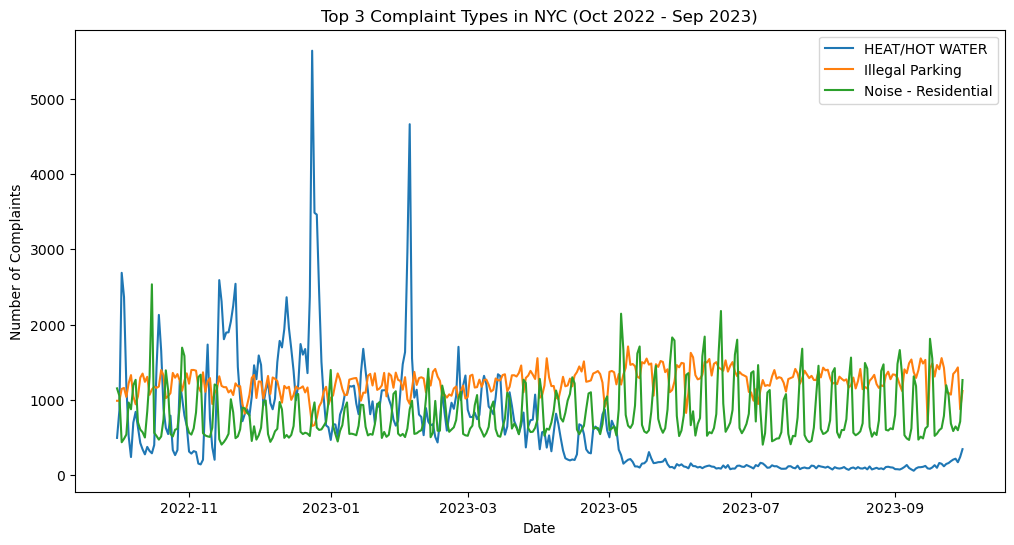

.
----------------------------------------------------------------------
Ran 1 test in 3.567s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [205]:
#!!!unit test
class TestPlotComplaintTypes(unittest.TestCase):
    def test_plot_complaint_types(self):
        # Setup: create a test engine (replace with your test database credentials)
        engine = create_engine('postgresql://localhost/FinalProject4501')

        # Example top complaint types
        top_complaint_types = ['Illegal Parking', 'Noise - Residential', 'HEAT/HOT WATER']

        # Initialize the variable to None
        raised_exception = None
        
        # Call the function inside a try-except block to catch exceptions
        try:
            plot_complaint_types(engine, top_complaint_types)
            exception_raised = False
        except Exception as e:
            exception_raised = True
            raised_exception = e

        # Assertions
        self.assertFalse(exception_raised, f"Function raised an exception: {raised_exception}")

# Create a test suite
suite = unittest.TestLoader().loadTestsFromTestCase(TestPlotComplaintTypes)

# Run the tests
unittest.TextTestRunner().run(suite)

In [ ]:
    """
    Generates a time-series plot of the daily count of top complaint types over a specified period.

    This function queries the 'three11' table in the database to fetch the daily count of complaints 
    for each of the top complaint types provided. It plots these counts over the time period from 
    October 1, 2022, to September 30, 2023. The function then visualizes this data in a line plot, 
    where each line represents one of the top complaint types.

    Parameters:
    - engine: The SQLAlchemy engine object for database connection and query execution.
    - top_complaint_types: A list of strings representing the top complaint types to be plotted.

    The function:
    - Formats the list of top complaint types for inclusion in a SQL query.
    - Executes a SQL query to retrieve the daily count of each complaint type within the specified date range.
    - Transforms the query results into a pivot table for easy plotting.
    - Generates a line plot with dates on the x-axis and complaint counts on the y-axis.

    Example:
    >>> engine = create_engine('postgresql://localhost/finalproject1')
    >>> top_complaint_types = ['Noise - Residential', 'Illegal Parking', 'Blocked Driveway']
    >>> plot_complaint_types(engine, top_complaint_types)

    Note:
    - The function assumes that the 'three11' table and the specified date range exist in the database.
    - It utilizes pandas for data manipulation and Matplotlib for plotting.
    - This function does not return any value; it directly displays the plot.
    """
    # Function implementation...


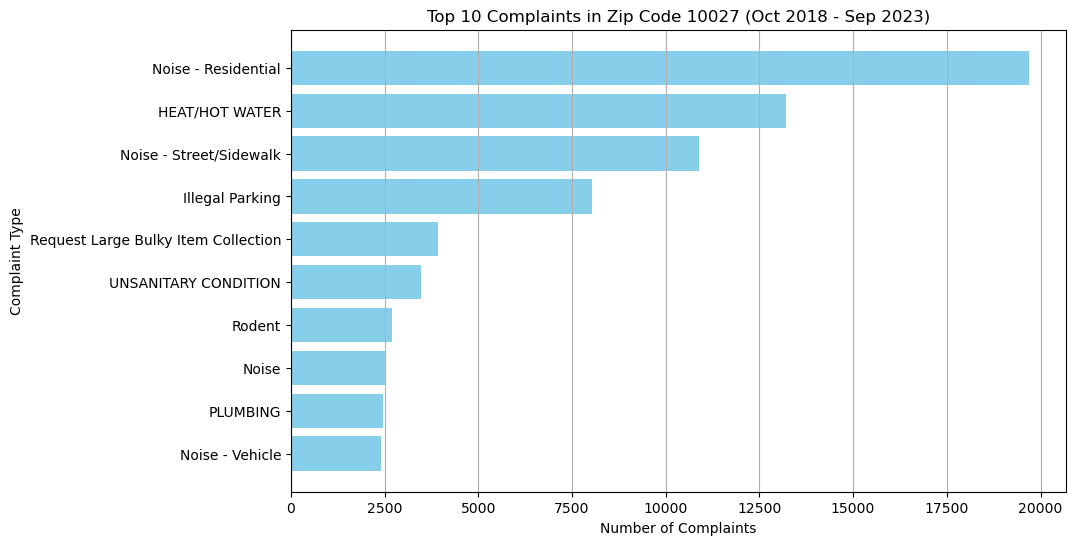

In [154]:
#2
import pandas as pd
import matplotlib.pyplot as plt

def plot_top_complaints_in_zipcode(engine):
    # Query to get top 10 complaint types in zip code 10027
    query = """
    SELECT complaint_type, COUNT(*) AS count
    FROM three11s
    WHERE zipcode = '10027' 
    AND created_date BETWEEN '2018-10-01' AND '2023-09-30'
    GROUP BY complaint_type
    ORDER BY count DESC
    LIMIT 10;
    """
    df = pd.read_sql(query, engine)

    # Sorting the dataframe for better visualization
    df.sort_values(by='count', ascending=True, inplace=True)

    # Creating the bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(df['complaint_type'], df['count'], color='skyblue')
    plt.xlabel('Number of Complaints')
    plt.ylabel('Complaint Type')
    plt.title('Top 10 Complaints in Zip Code 10027 (Oct 2018 - Sep 2023)')
    plt.grid(axis='x')
    plt.show()

# Call the function
plot_top_complaints_in_zipcode(engine)


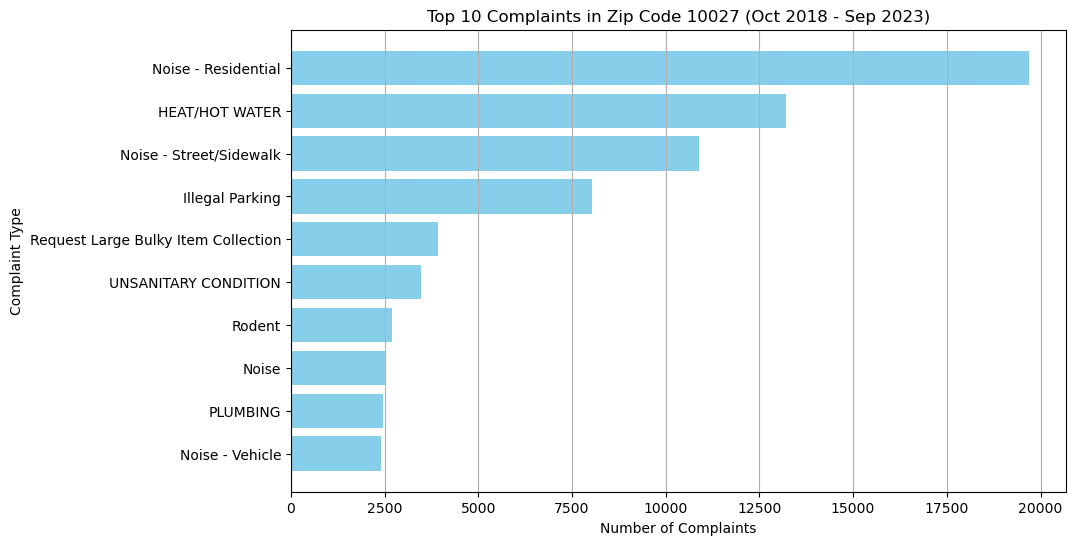

.
----------------------------------------------------------------------
Ran 1 test in 1.479s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [207]:
#!!!unit test
class TestPlotTopComplaintsInZipcode(unittest.TestCase):
    def test_plot_top_complaints_in_zipcode(self):
        # Setup: create a test engine (replace with your test database credentials)
        engine = create_engine('postgresql://localhost/FinalProject4501')

        # Initialize the variable to None
        raised_exception = None

        # Call the function inside a try-except block to catch exceptions
        try:
            plot_top_complaints_in_zipcode(engine)
            exception_raised = False
        except Exception as e:
            exception_raised = True
            raised_exception = e

        # Assertions
        self.assertFalse(exception_raised, f"Function raised an exception: {raised_exception}")

# Create a test suite
suite = unittest.TestLoader().loadTestsFromTestCase(TestPlotTopComplaintsInZipcode)

# Run the tests
unittest.TextTestRunner().run(suite)

In [ ]:
    """
    Generates a bar chart showing the top 10 complaint types in zip code 10027 over a specified period.

    This function queries the 'three11' table in the database to retrieve the count of different complaint 
    types in zip code 10027 from October 1, 2018, to September 30, 2023. The top 10 complaint types based 
    on frequency are then visualized in a horizontal bar chart. The chart displays complaint types along 
    the y-axis and their corresponding counts along the x-axis.

    Parameters:
    - engine: The SQLAlchemy engine object for database connection and query execution.

    The function:
    - Executes a SQL query to fetch the count of each complaint type in the specified zip code and date range.
    - Sorts the resulting data in ascending order for a more readable bar chart.
    - Generates a horizontal bar chart using Matplotlib, with customized aesthetics such as color and grid lines.

    Example:
    >>> engine = create_engine('postgresql://localhost/finalproject1')
    >>> plot_top_complaints_in_zipcode(engine)

    Note:
    - The function assumes the 'three11' table is present in the database with relevant data.
    - It uses pandas for data handling and Matplotlib for plotting.
    - This function does not return any value; it directly displays the plot.
    """


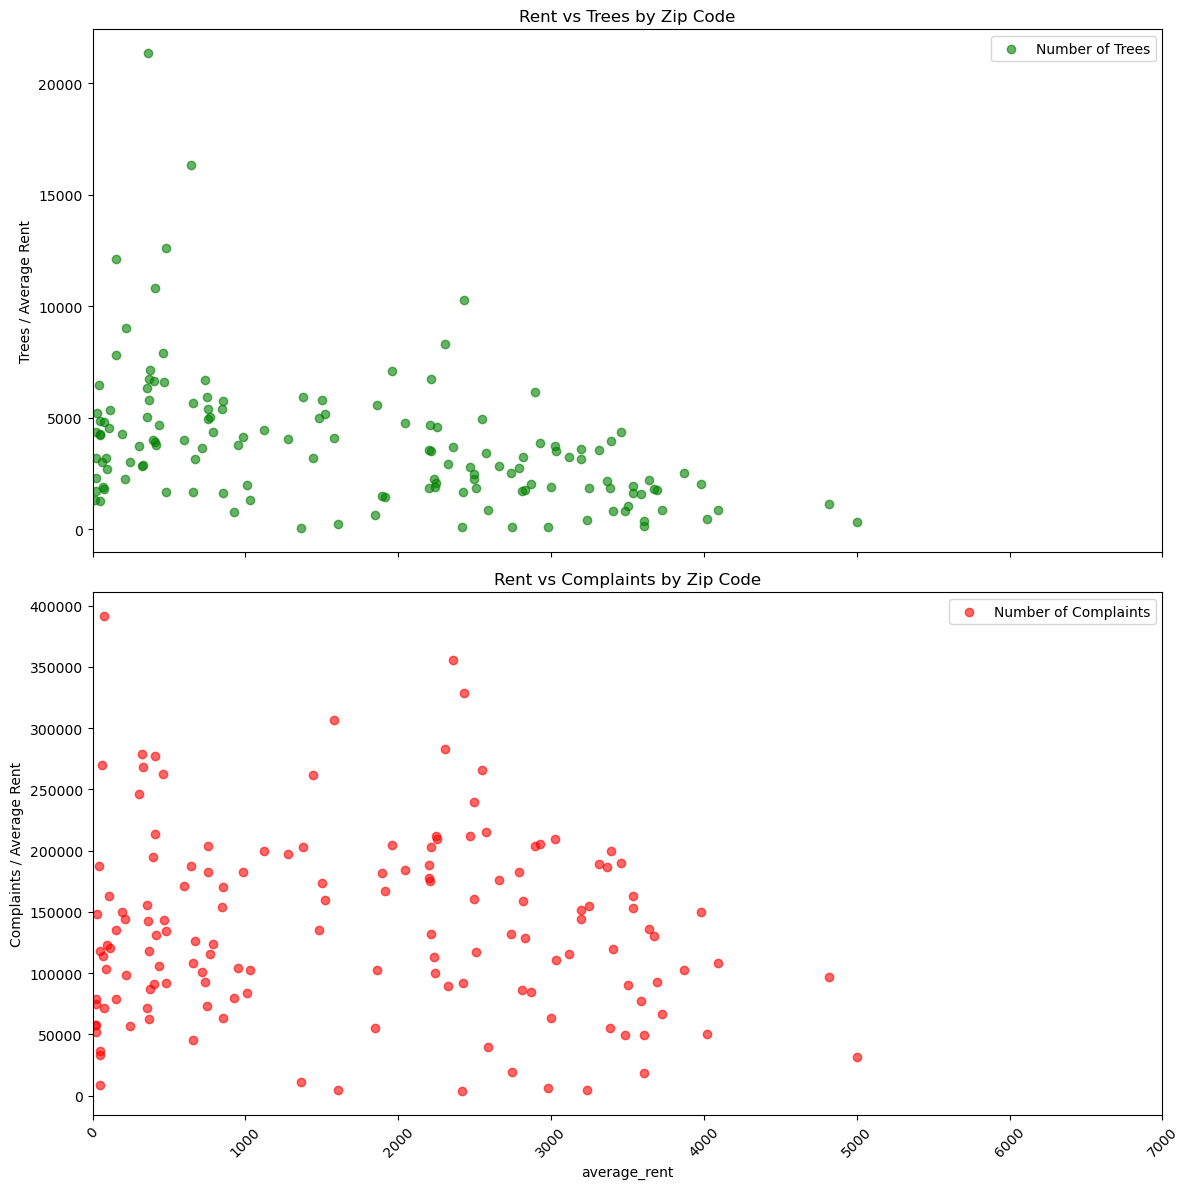

In [165]:
3
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect
engine = db.create_engine('postgresql://localhost/FinalProject4501')
# Database setup

def plot_rent_trees_complaints(engine):
    rent_query = """
    SELECT zipcode,
    ((AVG("2015-01-31") + AVG("2015-02-28") + AVG("2015-03-31")+
    AVG("2015-04-30") + AVG("2015-05-31") + AVG("2015-06-30") +
    AVG("2015-07-31") + AVG("2015-08-31") + AVG("2015-09-30") +
    AVG("2015-10-31") + AVG("2015-11-30") + AVG("2015-12-31") +
    AVG("2016-01-31") + AVG("2016-02-29") + AVG("2016-03-31") +
    AVG("2016-04-30") + AVG("2016-05-31") + AVG("2016-06-30") +
    AVG("2016-07-31") + AVG("2016-08-31") + AVG("2016-09-30") +
    AVG("2016-10-31") + AVG("2016-11-30") + AVG("2016-12-31") +
    AVG("2017-01-31") + AVG("2017-02-28") + AVG("2017-03-31") +
    AVG("2017-04-30") + AVG("2017-05-31") + AVG("2017-06-30") +
    AVG("2017-07-31") + AVG("2017-08-31") + AVG("2017-09-30") +
    AVG("2017-10-31") + AVG("2017-11-30") + AVG("2017-12-31") +
    AVG("2018-01-31") + AVG("2018-02-28") + AVG("2018-03-31") +
    AVG("2018-04-30") + AVG("2018-05-31") + AVG("2018-06-30") +
    AVG("2018-07-31") + AVG("2018-08-31") + AVG("2018-09-30") +
    AVG("2018-10-31") + AVG("2018-11-30") + AVG("2018-12-31") +
    AVG("2019-01-31") + AVG("2019-02-28") + AVG("2019-03-31") +
    AVG("2019-04-30") + AVG("2019-05-31") + AVG("2019-06-30") +
    AVG("2019-07-31") + AVG("2019-08-31") + AVG("2019-09-30") +
    AVG("2019-10-31") + AVG("2019-11-30") + AVG("2019-12-31") +
    AVG("2020-01-31") + AVG("2020-02-29") + AVG("2020-03-31") +
    AVG("2020-04-30") + AVG("2020-05-31") + AVG("2020-06-30") +
    AVG("2020-07-31") + AVG("2020-08-31") + AVG("2020-09-30") +
    AVG("2020-10-31") + AVG("2020-11-30") + AVG("2020-12-31") +
    AVG("2021-01-31") + AVG("2021-02-28") + AVG("2021-03-31") +
    AVG("2021-04-30") + AVG("2021-05-31") + AVG("2021-06-30") +
    AVG("2021-07-31") + AVG("2021-08-31") + AVG("2021-09-30") +
    AVG("2021-10-31") + AVG("2021-11-30") + AVG("2021-12-31") +
    AVG("2022-01-31") + AVG("2022-02-28") + AVG("2022-03-31") +
    AVG("2022-04-30") + AVG("2022-05-31") + AVG("2022-06-30") +
    AVG("2022-07-31") + AVG("2022-08-31") + AVG("2022-09-30") +
    AVG("2022-10-31") + AVG("2022-11-30") + AVG("2022-12-31") +
    AVG("2023-01-31") + AVG("2023-02-28") + AVG("2023-03-31") +
    AVG("2023-04-30") + AVG("2023-05-31") + AVG("2023-06-30") +
    AVG("2023-07-31") + AVG("2023-08-31") + AVG("2023-09-30")) / 105) AS average_rent
    FROM zillows
    GROUP BY zipcode;
    """

    tree_query = """
    SELECT zipcode, COUNT(*) AS tree_count
    FROM trees
    GROUP BY zipcode;
    """
    complaint_query = """
    SELECT zipcode, COUNT(*) AS complaint_count
    FROM three11s
    WHERE created_date BETWEEN '2015-01-01' AND '2023-09-30'
    GROUP BY zipcode;
    """

    # Fetching data from the database
    rent_df = pd.read_sql(rent_query, engine)
    tree_df = pd.read_sql(tree_query, engine)
    complaint_df = pd.read_sql(complaint_query, engine)

# Convert ZIPCODE columns to string
    rent_df['zipcode'] = rent_df['zipcode'].astype(str)
    tree_df['zipcode'] = tree_df['zipcode'].astype(str)
    complaint_df['zipcode'] = complaint_df['zipcode'].astype(str)
 
# Merge the dataframes on ZIPCODE
    merged_df = pd.merge(pd.merge(rent_df, tree_df, on='zipcode'), complaint_df, on='zipcode')
    
# Rest of your code for plotting...  
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 12), sharex=True)

# Rent vs. Number of Trees
    ax1.scatter(merged_df['average_rent'], merged_df['tree_count'], color='g', alpha=0.6, label='Number of Trees')
    #ax1.scatter(merged_df['zipcode'], merged_df['average_rent'], color='b', alpha=0.6, label='Average Rent')
    ax1.set_ylabel('Trees / Average Rent')
    ax1.set_title('Rent vs Trees by Zip Code')
    ax1.legend()

# Rent vs. Number of Complaints
    ax2.scatter(merged_df['average_rent'], merged_df['complaint_count'], color='r', alpha=0.6, label='Number of Complaints')
    #ax2.scatter(merged_df['zipcode'], merged_df['average_rent'], color='b', alpha=0.6, label='Average Rent')
    ax2.set_xlabel('average_rent')
    ax2.set_ylabel('Complaints / Average Rent')
    ax2.set_title('Rent vs Complaints by Zip Code')
    ax2.legend()

# Set the limits of the x-axis
    plt.xlim(0, 7000) 
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_rent_trees_complaints(engine)

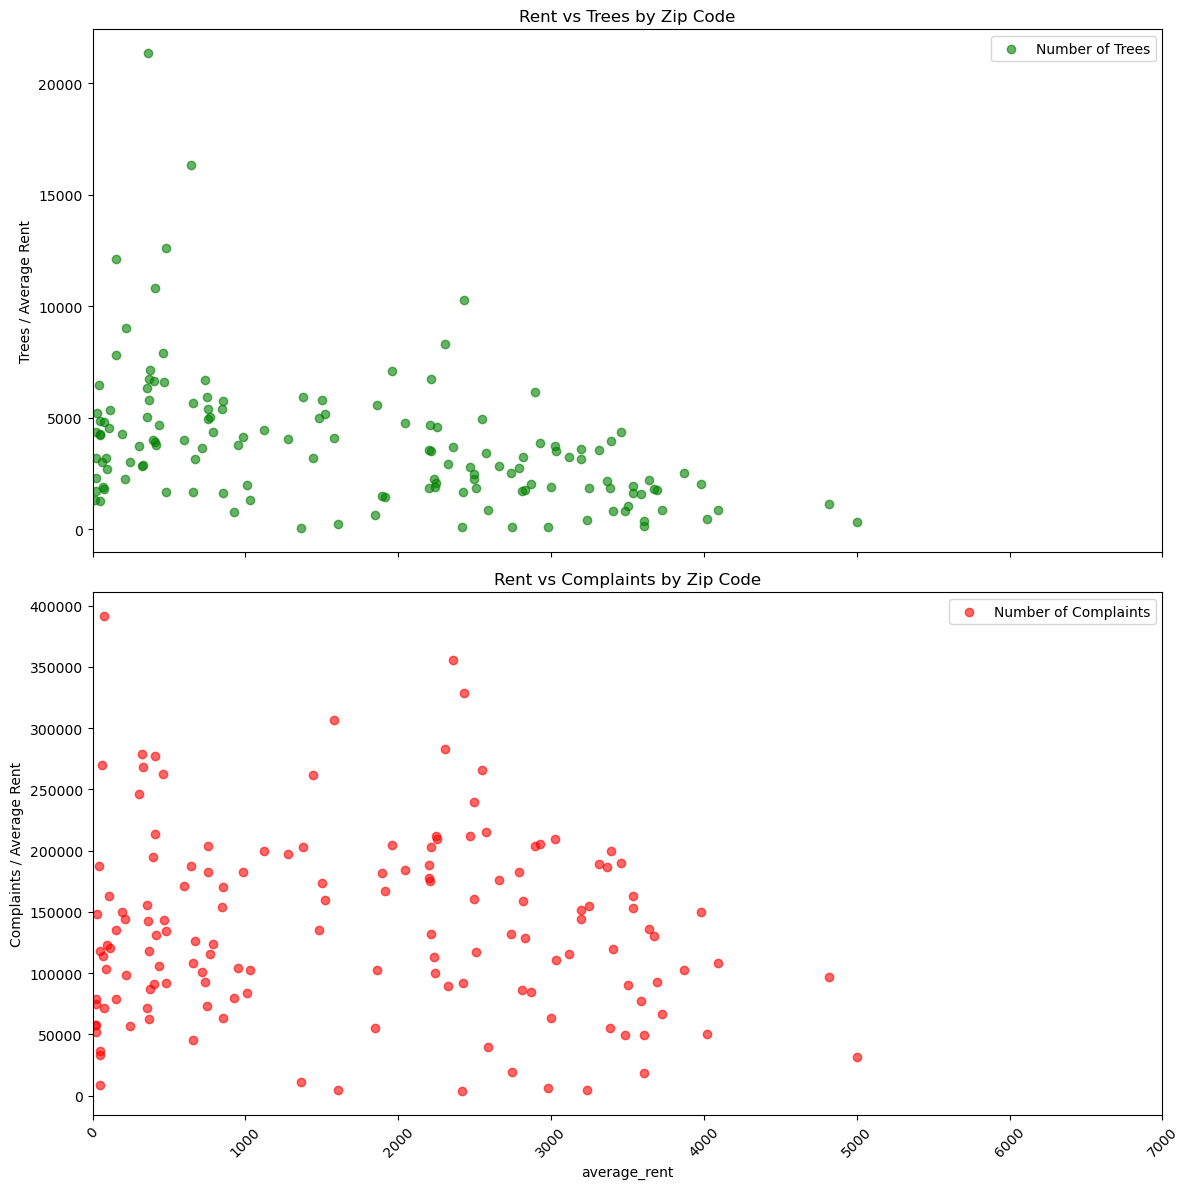

.
----------------------------------------------------------------------
Ran 1 test in 2.610s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [208]:
#!!!unit test
class TestPlotRentTreesComplaints(unittest.TestCase):
    def test_plot_rent_trees_complaints(self):
        # Setup: create a test engine (replace with your test database credentials)
        engine = create_engine('postgresql://localhost/FinalProject4501')

        # Initialize the variable to None
        raised_exception = None

        # Call the function inside a try-except block to catch exceptions
        try:
            plot_rent_trees_complaints(engine)
            exception_raised = False
        except Exception as e:
            exception_raised = True
            raised_exception = e

        # Assertions
        self.assertFalse(exception_raised, f"Function raised an exception: {raised_exception}")

# Create a test suite
suite = unittest.TestLoader().loadTestsFromTestCase(TestPlotRentTreesComplaints)

# Run the tests
unittest.TextTestRunner().run(suite)

In [ ]:
    """!!!the code has changed for visual 3
    Generates visualizations to compare the relationships between average rent, number of trees, 
    and number of complaints across different zip codes.

    This function performs three SQL queries to gather data on average rent (from the 'zillow' table), 
    number of trees (from the 'tree' table), and number of complaints (from the 'three11' table), 
    all grouped by zip code. It then merges these datasets and creates two subplot visualizations:
    1. A bar and line chart showing the number of trees and average rent by zip code.
    2. A bar and line chart showing the number of complaints and average rent by zip code.

    Parameters:
    - engine: The SQLAlchemy engine object for database connection and query execution.

    The function:
    - Retrieves and processes data from three different tables in the database.
    - Merges the datasets based on zip code.
    - Creates subplots using Matplotlib, with a shared x-axis (zip codes) and dual y-axes for each subplot.
    - Visualizes the data with bar charts (for trees and complaints) and line charts (for average rent).

    Example:
    >>> engine = create_engine('postgresql://localhost/finalproject1')
    >>> plot_rent_trees_complaints(engine)

    Note:
    - The function assumes the presence of 'zillow', 'tree', and 'three11' tables in the database with relevant data.
    - It utilizes pandas for data manipulation and Matplotlib for plotting.
    - This function does not return any value; it directly displays the plots.
    """

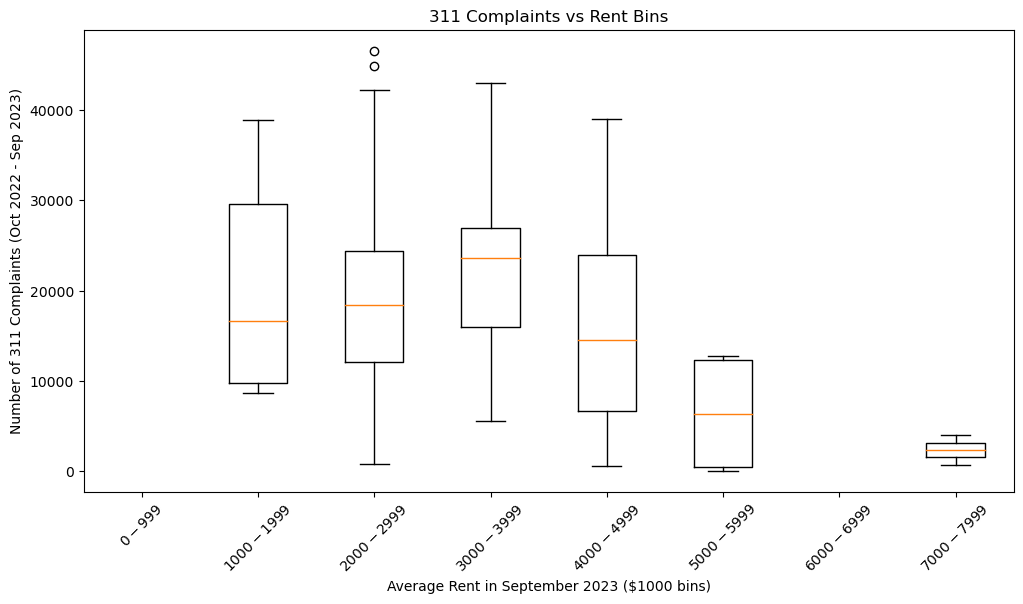

In [169]:
#4
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_rent_vs_complaints(engine):
    # SQL queries with the correct column names
    rent_query = """
    SELECT zipcode, "2023-09-30" AS average_rent_september_2023
    FROM zillows;
    """
    complaint_query = """
    SELECT zipcode, COUNT(*) AS complaint_count
    FROM three11s
    WHERE created_date BETWEEN '2022-10-01' AND '2023-09-30'
    GROUP BY zipcode;
    """

    rent_df = pd.read_sql(rent_query, engine)
    complaint_df = pd.read_sql(complaint_query, engine)

    # Convert 'zipcode' to string in both DataFrames
    rent_df['zipcode'] = rent_df['zipcode'].astype(str)
    complaint_df['zipcode'] = complaint_df['zipcode'].astype(str)

    # Merge the dataframes on ZIPCODE
    merged_df = pd.merge(rent_df, complaint_df, on='zipcode')

    # Check if max_rent is NaN or None
    max_rent = merged_df['average_rent_september_2023'].max()
    if pd.isna(max_rent):
        print("No rent data available for September 2023.")
        return

    # Creating bins for rent
    bins = np.arange(0, max_rent + 1000, 1000)
    merged_df['rent_bin'] = pd.cut(merged_df['average_rent_september_2023'], bins=bins, right=False)

    # Creating the boxplot
    plt.figure(figsize=(12, 6))
    # Group data by 'rent_bin' and prepare for boxplot
    boxplot_data = [group['complaint_count'] for name, group in merged_df.groupby('rent_bin')]
    boxplot_labels = [f"${int(interval.left)}-${int(interval.right)-1}" for interval in merged_df['rent_bin'].cat.categories]
    plt.boxplot(boxplot_data, labels=boxplot_labels)
    plt.xlabel('Average Rent in September 2023 ($1000 bins)')
    plt.ylabel('Number of 311 Complaints (Oct 2022 - Sep 2023)')
    plt.title('311 Complaints vs Rent Bins')
    plt.xticks(rotation=45)
    plt.show()

# Call the function
plot_rent_vs_complaints(engine)


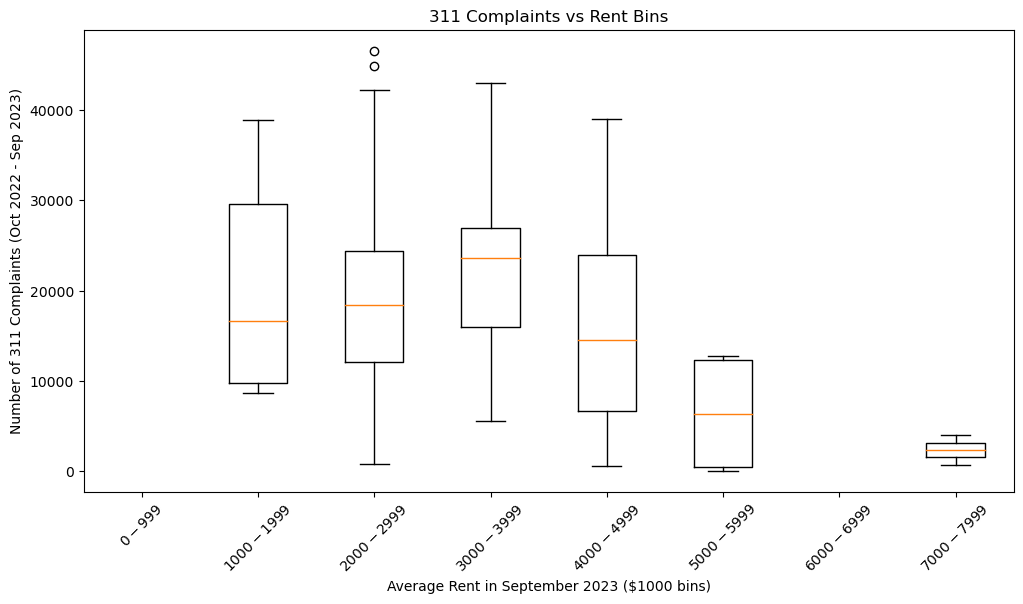

.
----------------------------------------------------------------------
Ran 1 test in 1.463s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [209]:
#!!!unit test
class TestPlotRentVsComplaints(unittest.TestCase):
    def test_plot_rent_vs_complaints(self):
        # Setup: create a test engine (replace with your test database credentials)
        engine = create_engine('postgresql://localhost/FinalProject4501')

        # Initialize the variable to None
        raised_exception = None

        # Call the function inside a try-except block to catch exceptions
        try:
            plot_rent_vs_complaints(engine)
            exception_raised = False
        except Exception as e:
            exception_raised = True
            raised_exception = e

        # Assertions
        self.assertFalse(exception_raised, f"Function raised an exception: {raised_exception}")

# Create a test suite
suite = unittest.TestLoader().loadTestsFromTestCase(TestPlotRentVsComplaints)

# Run the tests
unittest.TextTestRunner().run(suite)

In [ ]:
    """
    Generates a boxplot to visualize the distribution of 311 complaints in relation to rent price bins 
    across different zip codes.

    This function extracts data from the 'zillow' table for average rent as of September 2023 and from 
    the 'three11' table for the count of 311 complaints between October 2022 and September 2023, both 
    grouped by zip code. The data is merged based on zip codes, and a boxplot is created to show the 
    distribution of complaint counts across different rent price bins.

    Parameters:
    - engine: The SQLAlchemy engine object for database connection and query execution.

    The function:
    - Executes SQL queries to fetch rent and complaint data.
    - Merges the datasets based on zip code and creates rent bins.
    - Generates a boxplot using Matplotlib, where each box represents the distribution of complaint counts 
      within a specific rent bin.

    Example:
    >>> engine = create_engine('postgresql://localhost/finalproject1')
    >>> plot_rent_vs_complaints(engine)

    Note:
    - The function assumes the presence of 'zillow' and 'three11' tables in the database with relevant data.
    - It uses pandas for data handling and Matplotlib for plotting.
    - The function checks for missing data in the maximum rent value and handles it accordingly.
    - This function does not return any value; it directly displays the plot.
    """


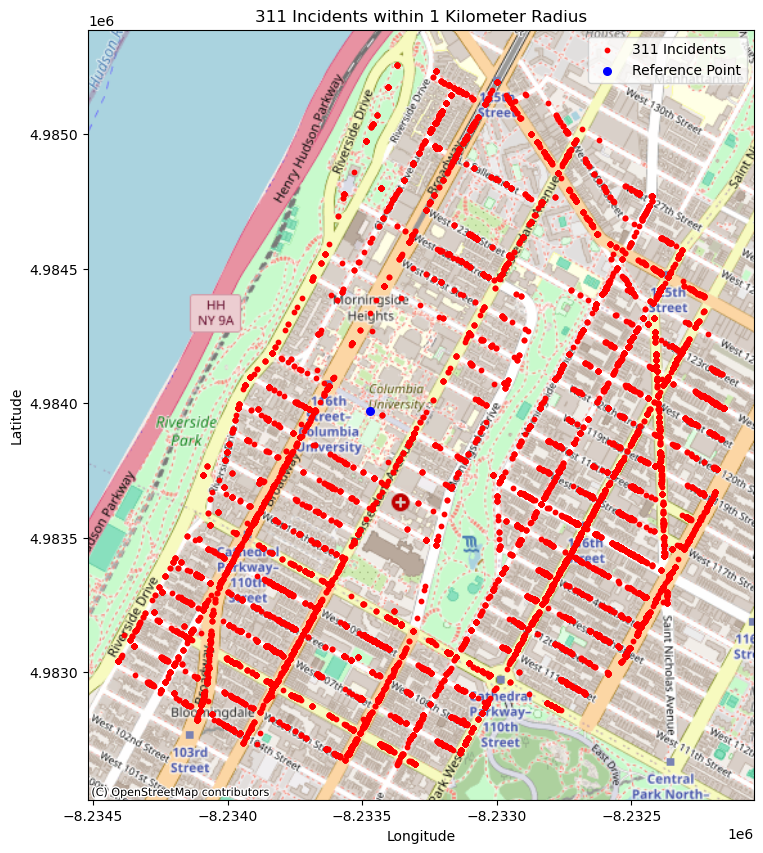

In [188]:
#5
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from geopy.distance import distance

def plot_nearby_311_incidents(engine, reference_point):
    # SQL query to get incident data
    query = """
    SELECT latitude, longitude
    FROM three11s
    WHERE created_date BETWEEN '2023-01-01' AND '2023-09-30';
    """
    df = pd.read_sql(query, engine)

    # Convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(
        df, 
        geometry=gpd.points_from_xy(df.longitude, df.latitude),
        crs="EPSG:4326"
    )

    # Filter out invalid or empty geometries
    gdf = gdf[gdf['geometry'].is_valid & ~gdf['geometry'].is_empty]

    # Reference point
    ref_point = Point(reference_point[1], reference_point[0])

    # Filter incidents within 1 kilometer
    gdf['distance'] = gdf['geometry'].apply(lambda x: distance((x.y, x.x), reference_point).km)
    nearby_incidents = gdf[gdf['distance'] <= 1]

    # Convert to Web Mercator for contextily
    gdf_web_mercator = nearby_incidents.to_crs(epsg=3857)
    ref_point_web_mercator = gpd.GeoSeries([ref_point], crs="EPSG:4326").to_crs(epsg=3857)

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf_web_mercator.plot(ax=ax, markersize=10, color='red', label='311 Incidents')
    ref_point_web_mercator.plot(ax=ax, markersize=30, color='blue', label='Reference Point')

    # Add contextily basemap
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('311 Incidents within 1 Kilometer Radius')
    plt.legend()
    plt.show()

# Example reference point (replace with the actual point)
reference_point = (40.80737875669467, -73.96253174434912) 
plot_nearby_311_incidents(engine, reference_point)


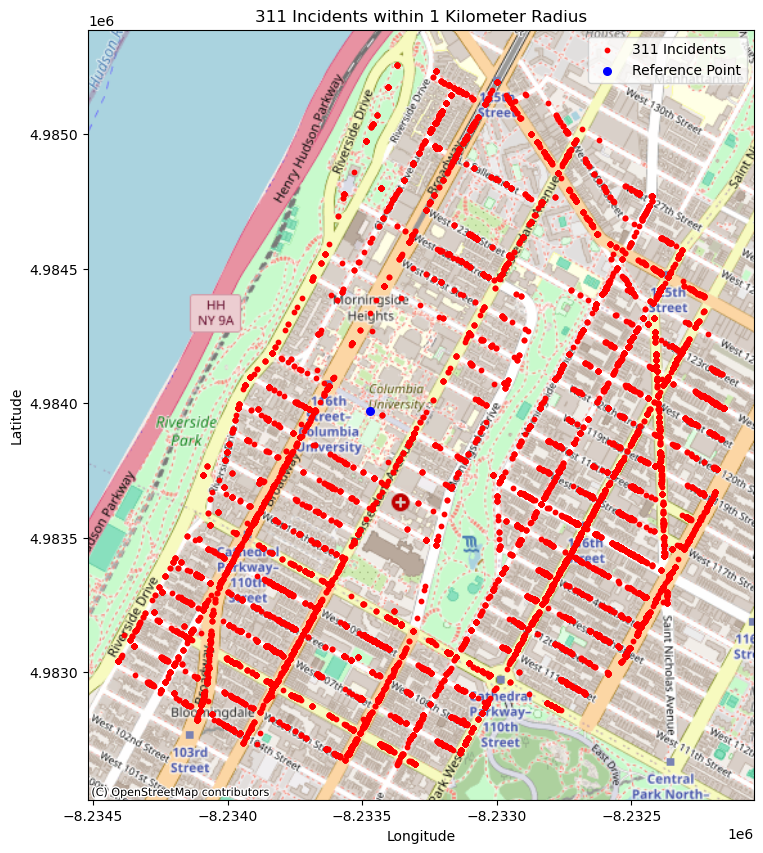

.
----------------------------------------------------------------------
Ran 1 test in 285.214s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [211]:
#!!!unit test
class TestPlotplotnearby311incidents(unittest.TestCase):
    def test_plot_nearby_311_incidents(self):
        # Setup: create a test engine (replace with your test database credentials)
        engine = create_engine('postgresql://localhost/FinalProject4501')

        # Example reference point
        reference_point = (40.80737875669467, -73.96253174434912)

        # Initialize the variable to None
        raised_exception = None

        # Call the function inside a try-except block to catch exceptions
        try:
            plot_nearby_311_incidents(engine, reference_point)
            exception_raised = False
        except Exception as e:
            exception_raised = True
            raised_exception = e

        # Assertions
        self.assertFalse(exception_raised, f"Function raised an exception: {raised_exception}")

# Create a test suite
suite = unittest.TestLoader().loadTestsFromTestCase(TestPlotplotnearby311incidents)

# Run the tests
unittest.TextTestRunner().run(suite)

In [ ]:
    """!!!engine='...FinalProject4501'
    Visualizes 311 incidents within a 1-kilometer radius of a given reference point using a geographical plot.

    This function queries the 'three11' table for latitude and longitude of incidents occurring between 
    January 1, 2023, and September 30, 2023. It converts these coordinates into a GeoDataFrame, and then 
    filters out incidents within 1 kilometer of a specified reference point. The function then plots these 
    nearby incidents and the reference point on a map.

    Parameters:
    - engine: The SQLAlchemy engine object for database connection and query execution.
    - reference_point: A tuple containing the latitude and longitude of the reference point (in the format (lat, lon)).

    The function:
    - Retrieves latitude and longitude of 311 incidents from the database.
    - Converts the data into a GeoDataFrame and filters for valid geometries.
    - Calculates the distance of each incident from the reference point and filters incidents within 1 kilometer.
    - Plots the nearby incidents and the reference point using Matplotlib and GeoPandas.

    Example:
    >>> engine = create_engine('postgresql://localhost/finalproject1')
    >>> reference_point = (40.7128, -74.0060)  # New York City coordinates
    >>> plot_nearby_311_incidents(engine, reference_point)

    Note:
    - The function assumes the 'three11' table is present in the database with latitude and longitude data.
    - It uses pandas, GeoPandas, and Shapely for data handling and Matplotlib for plotting.
    - This function does not return any value; it directly displays the plot.
    """


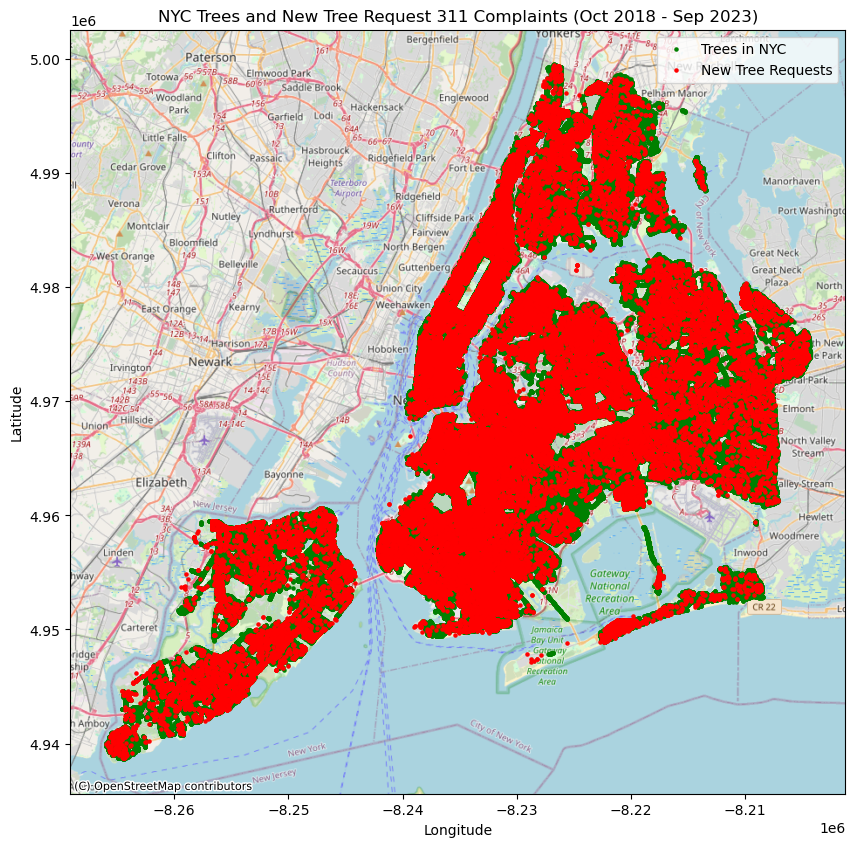

In [187]:
#6
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

def plot_trees_and_new_tree_requests(engine):
    # SQL queries to fetch data
    tree_query = "SELECT latitude, longitude FROM trees;"
    complaint_query = """
    SELECT latitude, longitude
    FROM three11s
    WHERE complaint_type = 'New Tree Request'
    AND created_date BETWEEN '2018-10-01' AND '2023-09-30';
    """

    tree_df = pd.read_sql(tree_query, engine)
    complaint_df = pd.read_sql(complaint_query, engine)

    # Convert to GeoDataFrames
    tree_gdf = gpd.GeoDataFrame(
        tree_df, 
        geometry=gpd.points_from_xy(tree_df.longitude, tree_df.latitude),
        crs="EPSG:4326"
    )
    complaint_gdf = gpd.GeoDataFrame(
        complaint_df, 
        geometry=gpd.points_from_xy(complaint_df.longitude, complaint_df.latitude),
        crs="EPSG:4326"
    )

    # Transform to Web Mercator (EPSG:3857) for contextily
    tree_gdf = tree_gdf.to_crs(epsg=3857)
    complaint_gdf = complaint_gdf.to_crs(epsg=3857)

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 10))
    tree_gdf.plot(ax=ax, markersize=5, color='green', label='Trees in NYC')
    complaint_gdf.plot(ax=ax, markersize=5, color='red', label='New Tree Requests')

    # Add contextily basemap
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('NYC Trees and New Tree Request 311 Complaints (Oct 2018 - Sep 2023)')
    plt.legend()
    plt.show()

# Call the function
plot_trees_and_new_tree_requests(engine)


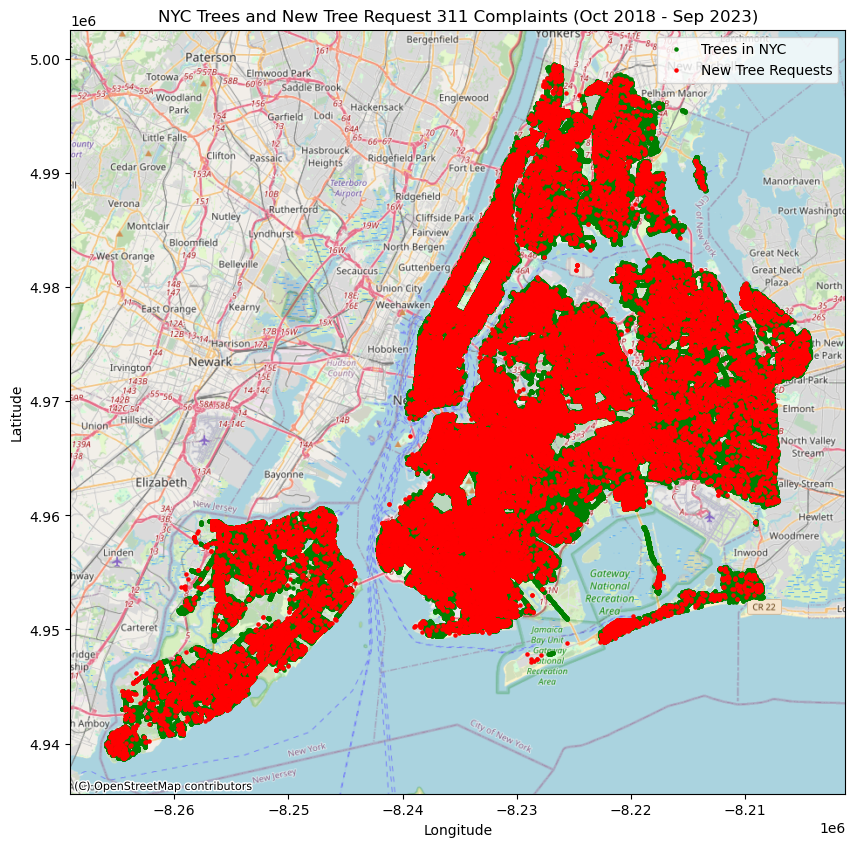

.
----------------------------------------------------------------------
Ran 1 test in 247.886s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [212]:
#!!!unit test
class TestPlotTreesAndNewTreeRequests(unittest.TestCase):
    def test_plot_trees_and_new_tree_requests(self):
        # Setup: create a test engine (replace with your test database credentials)
        engine = create_engine('postgresql://localhost/FinalProject4501')

        # Initialize the variable to None
        raised_exception = None

        # Call the function inside a try-except block to catch exceptions
        try:
            plot_trees_and_new_tree_requests(engine)
            exception_raised = False
        except Exception as e:
            exception_raised = True
            raised_exception = e

        # Assertions
        self.assertFalse(exception_raised, f"Function raised an exception: {raised_exception}")

# Create a test suite
suite = unittest.TestLoader().loadTestsFromTestCase(TestPlotTreesAndNewTreeRequests)

# Run the tests
unittest.TextTestRunner().run(suite)

In [ ]:
    """
    Plot trees and new tree request locations in NYC.

    This function retrieves data for existing trees and new tree requests in New York City
    from a database using SQL queries. It then converts these data sets into GeoDataFrames 
    and plots them on a map. The existing trees are represented as green points, and the 
    new tree requests, gathered from 311 complaints between October 2018 and September 2023,
    are shown as red points.

    Parameters:
    engine (SQLAlchemy Engine): A SQLAlchemy Engine object used to connect to and query the database.

    Returns:
    None: This function does not return any value. It displays a matplotlib plot showing the 
    distribution of trees and new tree requests across New York City.
    """
    